## Project NLP | Business Case: Automated Customer Reviews
Data preprocessing file,
I will be using the review and meta data from Amazon on Video games

# Downloads

In [ ]:
# The following downloads are needed to run this notebook
# !pip -q install transformers

# Libraries

In [77]:
# The following imports should be done to run this notebook
import numpy as np
import re, unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import json
import os, shutil

# Data import

In [30]:
# # Videogames
# !wget https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Video_Games.jsonl.gz
# !wget https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_Video_Games.jsonl.gz

In [31]:
# # Load Video Games
df_vg_reviews = pd.read_json(path_or_buf="Video_Games.jsonl.gz", lines=True, compression="gzip")
df_vg_meta    = pd.read_json(path_or_buf="meta_Video_Games.jsonl.gz", lines=True, compression="gzip")

## Taking a first look and adding sentiment

In [32]:
# Checking if there is missing data in reviews
df_vg_reviews.isnull().sum()


,0
rating,0
title,0
text,0
images,0
asin,0
parent_asin,0
user_id,0
timestamp,0
helpful_vote,0
verified_purchase,0


In [33]:
# Now checking for meta data
df_vg_meta.isnull().sum()

,0
main_category,11035
title,0
average_rating,0
rating_number,0
features,0
description,0
price,75261
images,0
videos,0
store,4361


In [34]:
# Adding sentiment labels of negative, neutral and positive
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:  # 4 or 5
        return "positive"

df_vg_reviews["sentiment"] = df_vg_reviews["rating"].apply(map_sentiment)


In [35]:
# Checking what the ratings/sentiment are looking like in the reviews
df_vg_reviews["sentiment"].value_counts(normalize=True)

,proportion
sentiment,
positive,0.744955
negative,0.181506
neutral,0.073538


## Data cleaning and merging

In [36]:
# Only keeping relevant columns from reviews data
df_vg_reviews = df_vg_reviews[[
    "rating", "sentiment", "text", "asin", "parent_asin",
    "timestamp", "helpful_vote", "verified_purchase"
]]

In [37]:
# Only keeping relevant columns from meta data
df_vg_meta = df_vg_meta[[
    "parent_asin", "title", "main_category", "average_rating",
    "rating_number", "categories", "price"
]]

In [38]:
# Merging the review and meta deta together
df = df_vg_reviews.merge(
    df_vg_meta,
    on="parent_asin",
    how="left"
)

In [39]:
# Checking on merged data
print(df.shape)
df.head(3)

(4624615, 14)


,rating,sentiment,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase,title,main_category,average_rating,rating_number,categories,price
0,4,positive,I’m playing on ps5 and it’s interesting. It’s...,B07DJWBYKP,B07DK1H3H5,2020-12-17 06:33:24.795,0,True,Cyberpunk 2077 - PC [Game Download Code in Box],Video Games,4.1,2015,"[Video Games, PC, Games]",None
1,5,positive,Nostalgic fun. A bit slow. I hope they don’t...,B00ZS80PC2,B07SRWRH5D,2020-04-16 15:31:54.941,1,False,Final Fantasy VII: Remake - PlayStation 4,Video Games,4.8,9097,"[Video Games, PlayStation 4, Games]",25.95
2,5,positive,This was an order for my kids & they have real...,B01FEHJYUU,B07MFMFW34,2017-03-30 12:37:11.000,0,True,Sid Meier’s Civilization VI: Rise and Fall [On...,Video Games,3.0,31,"[Video Games, PC, Games]",29.99


In [40]:
# Doing some minimal cleaning to the review text, we are keeping casing and punctuation since we will use pretrained models later.
def clean_text_transformer(text):
    if not isinstance(text, str):
        return ""
    text = unicodedata.normalize("NFKC", text)# normalizing unicode
    text = re.sub(r"<.*?>", " ", text)        # remove HTML tags
    text = re.sub(r"\s+", " ", text).strip()  # normalize spaces
    return text

df["clean_text"] = df["text"].apply(clean_text_transformer)

In [46]:
# Checking on cleaned text
print("Rows:", len(df))
df[["text", "clean_text"]].head(10)

Rows: 4624615


,text,clean_text
0,I’m playing on ps5 and it’s interesting. It’s...,I’m playing on ps5 and it’s interesting. It’s ...
1,Nostalgic fun. A bit slow. I hope they don’t...,Nostalgic fun. A bit slow. I hope they don’t s...
2,This was an order for my kids & they have real...,This was an order for my kids & they have real...
3,"These work great, They use batteries which is ...","These work great, They use batteries which is ..."
4,I would recommend to anyone looking to add jus...,I would recommend to anyone looking to add jus...
5,love all the amazing colors but the black is r...,love all the amazing colors but the black is r...
6,Instant delivery!,Instant delivery!
7,you should probably get these. you'll journal ...,you should probably get these. you'll journal ...
8,*it fits TWO wired Retro-bit 6 button controll...,*it fits TWO wired Retro-bit 6 button controll...
9,Sony and Amazon are collaborating in an Auto-r...,Sony and Amazon are collaborating in an Auto-r...


## Checking how our updated data is looking now.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624615 entries, 0 to 4624614
Data columns (total 15 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             int64         
 1   sentiment          object        
 2   text               object        
 3   asin               object        
 4   parent_asin        object        
 5   timestamp          datetime64[ns]
 6   helpful_vote       int64         
 7   verified_purchase  bool          
 8   title              object        
 9   main_category      object        
 10  average_rating     float64       
 11  rating_number      int64         
 12  categories         object        
 13  price              object        
 14  clean_text         object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(9)
memory usage: 498.4+ MB


In [49]:
df.describe(include="all")

,rating,sentiment,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase,title,main_category,average_rating,rating_number,categories,price,clean_text
count,4.624615e+06,4624615,4624615,4624615,4624615,4624615,4.624615e+06,4624615,4624615,4544849,4.624615e+06,4.624615e+06,4624615,3228004.00,4624615
unique,NaN,3,4047124,167645,137249,NaN,NaN,2,130694,36,NaN,NaN,509,8959.00,4044493
top,NaN,positive,Good,B01N3ASPNV,B01N3ASPNV,NaN,NaN,True,amFilm Tempered Glass Screen Protector for Nin...,Video Games,NaN,NaN,"[Video Games, PC, Games]",19.99,Good
freq,NaN,3445132,14140,18105,18105,NaN,NaN,3982807,18105,2880571,NaN,NaN,319665,101550.00,14140
mean,4.047460e+00,NaN,NaN,NaN,NaN,2017-08-24 18:16:11.273536512,1.227983e+00,NaN,NaN,NaN,4.303540e+00,6.240861e+03,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,NaN,NaN,1998-11-17 19:58:49,-1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN
25%,3.000000e+00,NaN,NaN,NaN,NaN,2015-03-06 10:19:18,0.000000e+00,NaN,NaN,NaN,4.100000e+00,1.790000e+02,NaN,NaN,NaN
50%,5.000000e+00,NaN,NaN,NaN,NaN,2018-03-14 22:52:57.208000,0.000000e+00,NaN,NaN,NaN,4.400000e+00,7.940000e+02,NaN,NaN,NaN
75%,5.000000e+00,NaN,NaN,NaN,NaN,2020-10-24 00:37:58.771500032,1.000000e+00,NaN,NaN,NaN,4.600000e+00,3.125000e+03,NaN,NaN,NaN
max,5.000000e+00,NaN,NaN,NaN,NaN,2023-09-12 09:02:35.529000,1.036900e+04,NaN,NaN,NaN,5.000000e+00,2.785740e+05,NaN,NaN,NaN


In [50]:
# The price looks off since it is not a float. So changing the dtype of price
def to_price(v):
    if pd.isna(v):
        return pd.NA
    s = str(v)
    # remove commas and currency symbols
    s = re.sub(r"[,$]", "", s)
    # extract first number
    m = re.search(r"\d+(?:\.\d+)?", s)
    return float(m.group()) if m else pd.NA

df["price"] = df["price"].apply(to_price).astype("Float64")

In [51]:
# checking on updated price column.
print(df["price"].describe())

count    3227913.0
mean     61.144839
std      97.869699
min            0.0
25%          17.97
50%          29.99
75%          59.99
max        3499.99
Name: price, dtype: Float64


## Saving data

In [52]:
# Saving our cleaned and merged data in to 1 new file, so we can callback on this later.
df.to_parquet("video_games_clean.parquet", index=False)

In [53]:
# Loading the new cleaned/merged data set, and small check if it is okay.
df = pd.read_parquet("video_games_clean.parquet")
print("Rows:", len(df))
df.head()

Rows: 4624615


,rating,sentiment,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase,title,main_category,average_rating,rating_number,categories,price,clean_text
0,4,positive,I’m playing on ps5 and it’s interesting. It’s...,B07DJWBYKP,B07DK1H3H5,2020-12-17 06:33:24.795,0,True,Cyberpunk 2077 - PC [Game Download Code in Box],Video Games,4.1,2015,"[Video Games, PC, Games]",<NA>,I’m playing on ps5 and it’s interesting. It’s ...
1,5,positive,Nostalgic fun. A bit slow. I hope they don’t...,B00ZS80PC2,B07SRWRH5D,2020-04-16 15:31:54.941,1,False,Final Fantasy VII: Remake - PlayStation 4,Video Games,4.8,9097,"[Video Games, PlayStation 4, Games]",25.95,Nostalgic fun. A bit slow. I hope they don’t s...
2,5,positive,This was an order for my kids & they have real...,B01FEHJYUU,B07MFMFW34,2017-03-30 12:37:11.000,0,True,Sid Meier’s Civilization VI: Rise and Fall [On...,Video Games,3.0,31,"[Video Games, PC, Games]",29.99,This was an order for my kids & they have real...
3,5,positive,"These work great, They use batteries which is ...",B07GXJHRVK,B0BCHWZX95,2019-12-29 16:40:34.017,0,True,PowerA Enhanced Wireless Controller for Ninten...,Video Games,4.6,19492,"[Video Games, Nintendo Switch, Accessories, Co...",67.61,"These work great, They use batteries which is ..."
4,5,positive,I would recommend to anyone looking to add jus...,B00HUWA45W,B00HUWA45W,2015-03-29 01:18:52.000,0,True,KontrolFreek FPS Freek CQC Signature - Xbox One,Computers,4.0,287,"[Video Games, Xbox One, Accessories]",<NA>,I would recommend to anyone looking to add jus...


## Data Analysis
Taking a better look at how our dataset is balanced. So we can make better decisions later on for example max token length.

In [54]:
# Data analysis step 1, taking a look at how our sentiment is balanced in this data set
# Order the classes for readability
order = ["negative", "neutral", "positive"]

counts = df["sentiment"].value_counts().reindex(order, fill_value=0)
props  = df["sentiment"].value_counts(normalize=True).reindex(order, fill_value=0)

# Table summary
sentiment_summary = pd.DataFrame({
    "count": counts,
    "proportion": (props * 100).round(2)
})
print(sentiment_summary)

             count  proportion
sentiment                     
negative    839397       18.15
neutral     340086        7.35
positive   3445132       74.50


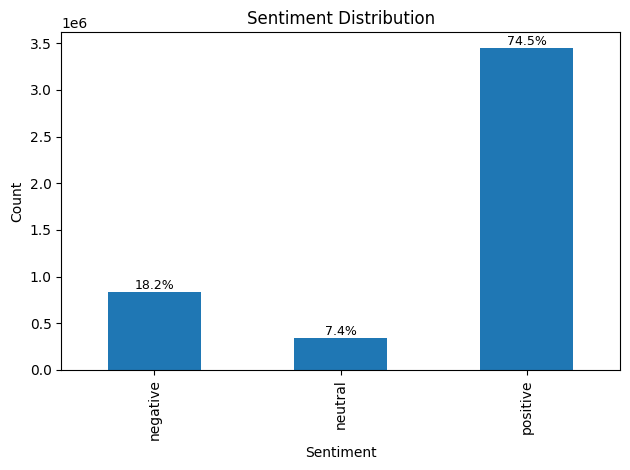

In [57]:
# Also visualizing in bars
plt.figure()
ax = counts.reindex(order).plot(kind="bar")
ax.set_title("Sentiment Distribution")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")

# annotate bars with percentages
for p, pct in zip(ax.patches, (props.reindex(order) * 100)):
    ax.text(p.get_x() + p.get_width()/2, p.get_height(),
            f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

count    4,624,615.000
mean            56.236
std            114.720
min              0.000
50%             24.000
75%             57.000
90%            127.000
95%            209.000
99%            530.000
max          5,931.000
Name: n_words, dtype: object


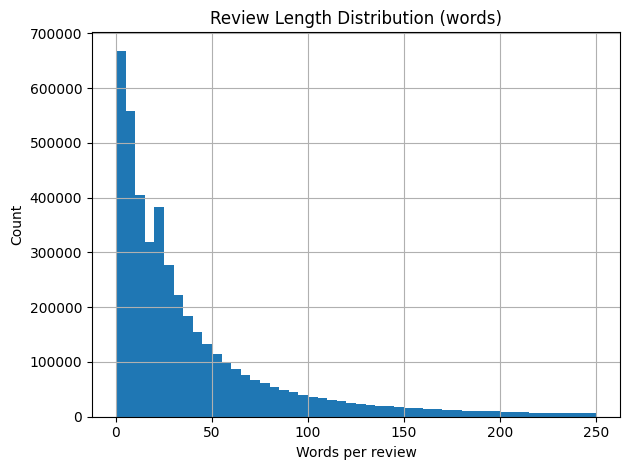

In [ ]:
# Data analysis step 2, checking length distribution (by words)
# compute word counts
df["n_words"] = df["clean_text"].str.split().str.len()

# summary (key percentiles)
s = df["n_words"].describe(percentiles=[.5, .75, .9, .95, .99])
print(s.map(lambda x: f"{x:,.3f}"))

# quick histogram (clipping long tail for readability)
plt.figure()
ax = df["n_words"].hist(bins=50, range=(0, 250))
ax.set_title("Review Length Distribution (words)")
ax.set_xlabel("Words per review")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

Seems that most reviews (95%) are 209 words or less. After tokenizing lenght will increase normally between x1.3 to x1.5. For the top 1% this will be an issue since the models we use later are capped.

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


count    50000.00
mean        71.76
std        141.21
min          2.00
50%         32.00
75%         72.00
90%        159.00
95%        263.00
99%        685.00
max       5098.00
Name: n_tokens, dtype: object


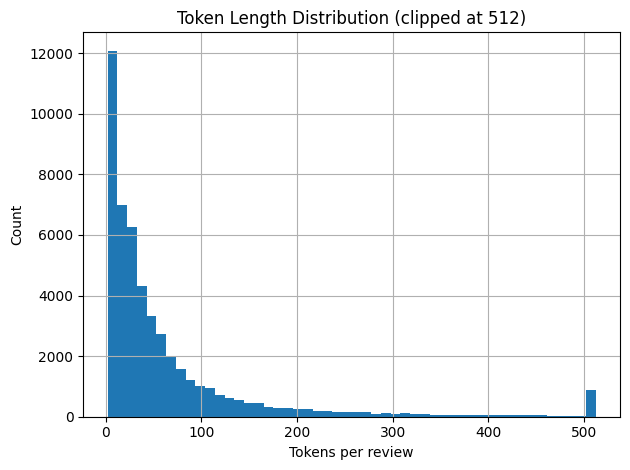

In [ ]:
# Data analysis step 3, using distilbert-base-uncased, 1 of the suggested models, to find max token lenght
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# sample to keep it fast in Colab
sample_texts = df["clean_text"].dropna().sample(n=50000, random_state=23).tolist()

# batch tokenize WITHOUT truncation to measure true lengths
enc = tokenizer(sample_texts, padding=False, truncation=False, add_special_tokens=True)
tok_lens = pd.Series([len(ids) for ids in enc["input_ids"]], name="n_tokens")

# summary with nice formatting
summary = tok_lens.describe(percentiles=[.5, .75, .9, .95, .99])
print(summary.map(lambda x: f"{x:.2f}"))

# quick histogram (clipping at BERT's 512-token cap for readability)
plt.figure()
tok_lens.clip(upper=512).hist(bins=50)
plt.title("Token Length Distribution (clipped at 512)")
plt.xlabel("Tokens per review")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Max length of 256 should probably be used.

count    4624615.00
mean           1.23
std           15.82
min           -1.00
50%            0.00
75%            1.00
90%            2.00
95%            4.00
99%           18.00
max        10369.00
Name: helpful_vote, dtype: object
Negatives: 1


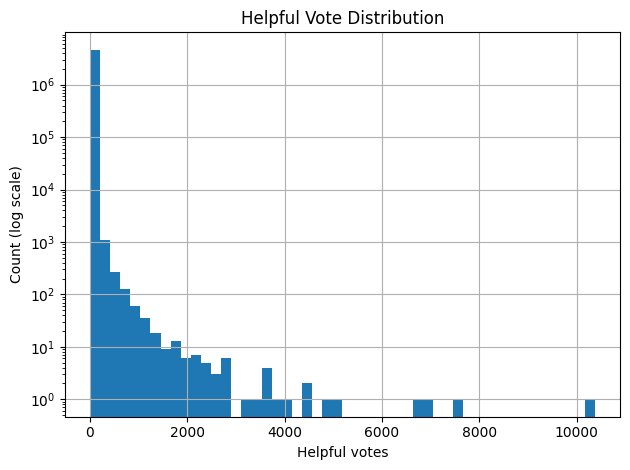


Mean helpful votes by sentiment:
sentiment
negative    2.16
neutral     1.52
positive    0.97
Name: helpful_vote, dtype: float64


In [71]:
# Data analysis step 4, having a look at the helpful votes
# summary + check for negatives (we saw min could be -1)
hv = df["helpful_vote"]
summary = hv.describe(percentiles=[.5,.75,.9,.95,.99])
print(summary.map(lambda x: f"{x:.2f}"))
print("Negatives:", (hv < 0).sum())

# histogram with log y-scale (heavy right tail)
plt.figure()
ax = hv.clip(lower=0).hist(bins=50)
ax.set_yscale("log")
ax.set_title("Helpful Vote Distribution")
ax.set_xlabel("Helpful votes")
ax.set_ylabel("Count (log scale)")
plt.tight_layout()
plt.show()

# By-sentiment averages (can inform weighting in summarization)
print("\nMean helpful votes by sentiment:")
print(df.groupby("sentiment")["helpful_vote"].mean().round(2))

There seem to be negative values that should not be possible, as not helpful did not exist on Amazon in 2023. And people seem more inclined to put helpful votes on negative reviews

In [72]:
neg_mask = df["helpful_vote"] < 0
neg_count = int(neg_mask.sum())
neg_pct = 100 * neg_count / len(df)

print(f"Negative helpful_vote rows: {neg_count} ({neg_pct:.6f}% of data)")
print("\nValues and counts:")
print(df.loc[neg_mask, "helpful_vote"].value_counts())

Negative helpful_vote rows: 1 (0.000022% of data)

Values and counts:
helpful_vote
-1    1
Name: count, dtype: int64


Seems to be only 1 bugged review with a negative helpful vote,

In [73]:
# removing the bugged review
df["helpful_vote"] = df["helpful_vote"].clip(lower=0)

Missing price %: 30.20%
count    3,227,913.00
mean            61.14
std             97.87
min              0.00
50%             29.99
75%             59.99
90%            138.68
95%            233.98
99%            479.99
max          3,499.99
Name: price, dtype: object


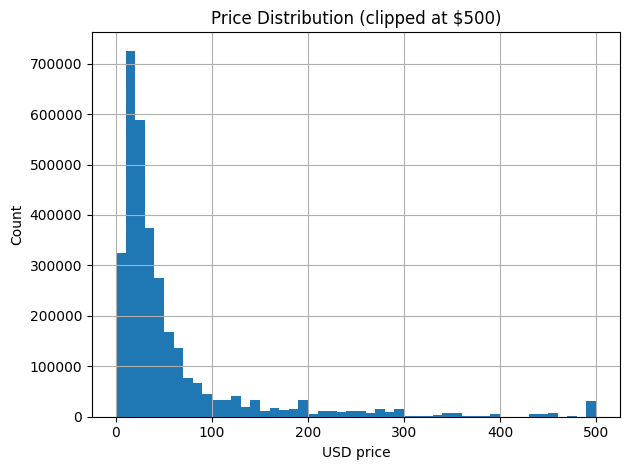

In [74]:
# Data analysis step 5, having a look at price
p = df["price"]

print(f"Missing price %: {p.isna().mean()*100:.2f}%")
print(p.describe(percentiles=[.5, .75, .9, .95, .99]).map(lambda x: f"{x:,.2f}"))

plt.figure()
p.dropna().clip(upper=500).hist(bins=50)
plt.title("Price Distribution (clipped at $500)")
plt.xlabel("USD price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Saving preprocessing

In [76]:
# Saving preprocessing
# ensure dtypes are clean
df["price"] = df["price"].astype("Float64")
df["verified_purchase"] = df["verified_purchase"].astype("boolean")
df["helpful_vote"] = pd.to_numeric(df["helpful_vote"], errors="coerce").astype("Int64")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# label mapping and id column
LABEL2ID = {"negative": 0, "neutral": 1, "positive": 2}
df["sentiment_id"] = df["sentiment"].map(LABEL2ID).astype("int8")

# select/order columns for downstream work
cols = [
    "clean_text", "sentiment", "sentiment_id", "rating",
    "parent_asin", "asin", "title", "categories",
    "price", "average_rating", "rating_number",
    "verified_purchase", "helpful_vote", "timestamp"
]
df_out = df[cols].copy()

# save full dataset
df_out.to_parquet("video_games_preprocessed.parquet", index=False)

# save a 1% stratified sample for fast experiments
sample = (df_out.groupby("sentiment", group_keys=False)
                 .apply(lambda x: x.sample(frac=0.01, random_state=42)))
sample.to_parquet("video_games_preprocessed_sample1pct.parquet", index=False)

# save a small config for the classification notebook
MAX_LENGTH = 256  # chosen from token-length EDA
counts = df_out["sentiment"].value_counts().to_dict()
class_weights = {k: (len(df_out) / (len(LABEL2ID) * counts[k])) for k in LABEL2ID}  # inverse-freq

cfg = {
    "text_col": "clean_text",
    "label_col": "sentiment",
    "label2id": LABEL2ID,
    "max_length": MAX_LENGTH,
    "class_counts": counts,
    "class_weights": class_weights
}
with open("preprocess_config.json", "w") as f:
    json.dump(cfg, f, indent=2)

print("Saved:")
print(" - video_games_preprocessed.parquet:", len(df_out), "rows")
print(" - video_games_preprocessed_sample1pct.parquet:", len(sample), "rows")
print(" - preprocess_config.json:", cfg)


/tmp/ipython-input-1790059424.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.01, random_state=42)))


Saved:
 - video_games_preprocessed.parquet: 4624615 rows
 - video_games_preprocessed_sample1pct.parquet: 46246 rows
 - preprocess_config.json: {'text_col': 'clean_text', 'label_col': 'sentiment', 'label2id': {'negative': 0, 'neutral': 1, 'positive': 2}, 'max_length': 256, 'class_counts': {'positive': 3445132, 'negative': 839397, 'neutral': 340086}, 'class_weights': {'negative': 1.8364830149897287, 'neutral': 4.532789745338924, 'positive': 0.44745406949090294}}


In [ ]:
# Saving the docs needed for next notebooks.
from google.colab import drive
drive.mount('/content/drive')

DEST = "/content/drive/MyDrive/Project_NLP"
os.makedirs(DEST, exist_ok=True)

files = [
    "video_games_preprocessed.parquet",
    "video_games_preprocessed_sample1pct.parquet",
    "preprocess_config.json",
]
for f in files:
    shutil.copy(f, DEST)
    print("Copied ->", os.path.join(DEST, f))


Mounted at /content/drive
Copied -> /content/drive/MyDrive/Project_NLP/video_games_preprocessed.parquet
Copied -> /content/drive/MyDrive/Project_NLP/video_games_preprocessed_sample1pct.parquet
Copied -> /content/drive/MyDrive/Project_NLP/preprocess_config.json


In [80]:
# quick load test (sample + config)
df_sample = pd.read_parquet(f"{DEST}/video_games_preprocessed_sample1pct.parquet")
cfg = json.load(open(f"{DEST}/preprocess_config.json"))
print("sample rows:", len(df_sample), "| max_length:", cfg["max_length"])

sample rows: 46246 | max_length: 256
